In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization

from numba import njit

import copy

import numpy as np
import scipy as scy
import math as math

In [3]:
class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int, boundary:bool, rng_seed:int|None=None):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        n_Particles : an integer of the number of Particles in the box. Needed to initialize all arrays correctly.\n
        boundary    : Wether the box_borders are hard boundaries.\n
        rng_seed    : Random Number Generator seed for reproducible results. None for random seed.
        """
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol

        self.box_size       = box_size
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        self.particles_pos  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_vel  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_acc  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)

        # All of the radii stored in an array
        # Additionally the combined raddii are calculated for each pair
        self.particles_r    = np.zeros(n_Particles, dtype=float)
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:] # shape (n,n)

        # All of the masses are stored in an array
        self.particles_m    = np.zeros(n_Particles, dtype=float)
        
        # We use distance matrices for true distances (distances_mat) in x and y coords, 
        # distances with ghost particles for cross boundary calculations (distance_ghost) in x and y coords
        # and the norm of the ghost_distances as a single float
        self.distance_mat   = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.distance_ghost = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.distance_abs   = np.zeros((n_Particles,n_Particles), dtype=float)
        self.distance_abs_ghost   = np.zeros((n_Particles,n_Particles), dtype=float)
        # A vectorial force matrix to store the forces between each pair of particles in both directions
        self.force_mat      = np.zeros((n_Particles,n_Particles,2), dtype=float)
        # Storing the energy types currently in the system
        self.potEnergy_mat  = np.zeros((n_Particles,n_Particles), dtype=float)
        self.kinEnergy_mat  = np.zeros((n_Particles), dtype=float)

        # The  current temperatur of the entire system
        self.temp:float = 0. # K
        # The number of particles as an int
        self.n_particles:int = n_Particles
        # Wether a boundary at the edge of the box exists:
        self.boundary = boundary

        # Random Number Generator used with seed
        self.rng = np.random.default_rng(seed=rng_seed)


    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")



    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass
            
        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)
        
        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        """
        Check which alignment method should be choosen and fill the positions accoringly
        """
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)
        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.01 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'left-grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally, the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]/2-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        

    def move(self, dt:float = 1.0, vel = [], particles = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt          : the time-step moving forward; default = 1\n
        vel         : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        particles   : The particles that should be moved as indices for the position array of this class; default(empty) = all particles
        """
        if len(particles) == 0:
            if len(vel) == 0:
                vel = self.particles_vel
            self.particles_pos += vel*dt
        else:
            if len(vel) == 0:
                vel = self.particles_vel[particles]
            self.particles_pos[particles] += vel*dt

    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size


        

    def calculate_distance_matrix(self) -> None:
        """Calculates a matrix, containing x and y distances of all particles to all other particles in both directions.\n
        It is by nature not symmetric, but rather the upper triangle is negated and flipped"""
        self.distance_mat = self.particles_pos[np.newaxis, :, :] - self.particles_pos[:, np.newaxis, :] # shape: (n,n,2)
        # The norm is calculated as well as the absolute distance between each Particle pair. Symmetric by nature
        self.distance_abs = np.linalg.vector_norm(self.distance_mat, axis = 2) # shape: (n,n)
        
        if self.boundary:
            # the ghost matrix is calculated to account for interactions that go over the boundary of the box.
            # This is adjusted, if the x or y distances is greater than half the box size, which makes the distance across boundaries shorter
            self.distance_ghost = np.where(self.distance_mat[:, :] > (0.5 * self.box_size), 
                                        self.distance_mat[:, :] - self.box_size, self.distance_mat[:, :]) # shape: (n,n,2)
            self.distance_ghost = np.where(self.distance_ghost[:, :] < -(0.5 * self.box_size), 
                                        self.distance_ghost[:, :] + self.box_size, self.distance_ghost[:, :]) # shape: (n,n,2)
            
            self.distance_abs_ghost = np.linalg.vector_norm(self.distance_ghost, axis = 2) # shape: (n,n)
        


In [4]:
class LennardJones(Box):
    """
    A box that implements the Lennard-Jones type particle system
    """
    def __init__(self, box_size, n_Particles: int, boundary:bool, rng_seed:int|None=None):
        super().__init__(box_size, n_Particles, boundary, rng_seed)

    
    def update_pos(self, dt) -> None:
        """Updates the position according to the velocity-verlet algorithm\n
        dt  : The time step used
        """
        self.particles_pos = self.particles_pos + self.particles_vel*dt + 1/2*(self.particles_acc*dt**2)
        # always wrap around...
        self.wrap_around()
    
    def update_vel_acc(self, dt, lammda) -> None:
        """Updates the velocities according to the velocity-verlet algorithm. Therefore the updated accelerations are needed.\n
        dt  : The time step used
        """
        new_acc = self.calculate_acc()
        self.particles_vel = (self.particles_vel + 0.5*(self.particles_acc + new_acc)*dt) * lammda
        self.particles_acc = new_acc

    def calculate_acc(self):
        """Updates the accelerations according to the velocity-verlet algorithm\n
        """
        return np.sum(self.force_mat,axis=0)/self.particles_m[:,np.newaxis]
    
    def calculate_temp(self):
        """Updates the temperature of the system. For this a recalculation of the kinetic energies is necessary"""
        self.calculate_kinEnergy_matrix()
        self.temp = np.sum(self.kinEnergy_mat)/self.kB/self.avogadro

    def calculate_lammda(self, tau, target_temp, dt):
        """Calculates the lambda of the berendsen thermostat. If the temperature is zero, it gives back zero."""
        self.calculate_temp()
        if self.temp != 0:
            return np.sqrt(1 + (dt/tau)*(target_temp/self.temp - 1))
        else:
            print(f'temp is zero!!')
            return 0

    


    def calculate_force_matrix(self) -> None:
        """Calculate the forces acting from each Particle onto each particle as a directional vector stored in a matrix"""
        if self.boundary: # not really necessary innit? Never have boundary for lennard jones. But might implement at some point
            distance_abs_newaxis = self.distance_abs[:, :, np.newaxis] # shape: (n,n,1); used for better matrix multiplication with numpy
            # We have to check for any distances of zero between Particles, which would not allow for any force-calculation
            # We set those forces to zero
            self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*
                                                                self.c_6/distance_abs_newaxis**8)*self.distance_mat, 0)
        else:
            distance_abs_newaxis = self.distance_abs_ghost[:, :, np.newaxis] # shape: (n,n,1); used for better matrix multiplication with numpy
            # We have to check for any distances of zero between Particles, which would not allow for any force-calculation
            # We set those forces to zero
            self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*
                                                                self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)

    def calculate_potEnergy_matrix(self) -> None:
        """Calculate the potential energy of the system"""
        # Again we need to account for any division by zero
        if self.boundary:
            self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-
                                                               self.c_6/(self.distance_abs**6)), 0) # shape: (n,n)
        else:
            self.potEnergy_mat = np.where(self.distance_abs_ghost != 0, (self.c_12/(self.distance_abs_ghost**12)-
                                                               self.c_6/(self.distance_abs_ghost**6)), 0) # shape: (n,n)

    def calculate_kinEnergy_matrix(self) -> None:
        """Calculate the current kinetic energy in the system."""
        self.kinEnergy_mat = 0.5 * self.particles_m * np.square(np.linalg.norm(self.particles_vel, axis=1)) # shape: (n) #could be optimized maybe? square of squareroot of squares






    def update_step(self, target_temp, dt, thermostat = 'no', tau = 2e-3) -> None:
        """The heart of the velocity-verlet algoritm.\n
        dt  : The time step used
        """
        self.update_pos(dt)
        # Before calculating the new velocities/accelerations, the forces must be calculated, for which we need the distance_matrix
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        # if a thermostat is used, take a different lambda into account
        if thermostat == 'berends':
            lammda = self.calculate_lammda(tau, target_temp, dt)
        elif thermostat == 'no':
            lammda = 1
        self.update_vel_acc(dt, lammda)







    def steepest_descent(self, distance = 0.05, counter = 100, accuracy = 1.):
        """Does a steepest descent search for this box to find an energetically optimal position.\n
        distance    : How far the particles should move in one time-step, default: for now 0.05nm; might change in the future - lower gives better results\n
        counter     : How many re-calculations of the forces should maximally happen, default: 100
        accuracy    : How accurat the end-position has to be to stop the search, default: 1
        """
        # store the potential energy of the system at each step
        pot_energies = []
        # calculate forces and energy for the initial time-step
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        self.calculate_potEnergy_matrix()
        pot_energies.append(self.potEnergy_mat)
        pot_energy_old = np.sum(self.potEnergy_mat)/2
        
        #counting upwards, relict from previous iteration. Dont want to change that now
        i = 0
        # run the while-loop until the counter is reached
        while i < counter:
            # Calculate the normalized direction to move in for all Particles
            move_direction = np.sum(self.force_mat,axis=0)
            move_direction = np.divide(move_direction,np.linalg.norm(move_direction))
            # Move in that direction until the bottom is reached
            pathway = True
            while pathway:
                self.move(dt=distance, vel=move_direction)
                self.calculate_distance_matrix()
                self.calculate_potEnergy_matrix()

                pot_energy_new_mat = self.potEnergy_mat
                pot_energy_new = np.sum(pot_energy_new_mat)/2
                # Check wether next energy is lower than previous one
                if pot_energy_new < np.sum(pot_energies[-1])/2:
                    # save the new energies
                    pot_energies.append(pot_energy_new_mat)
                else:
                    # move backwards to the last place
                    self.move(dt=-distance, vel=move_direction)
                    # recalculate the forces
                    self.calculate_distance_matrix()
                    self.calculate_force_matrix()
                    # count upwards and recalculate the moving direction in the next while-loop-iteration
                    i += 1
                    pathway = False
            # Check wether a local minimum is reached either if the energies get smaller insignificantly 
            # or the new energies never get lower (mostly due to a large step size, so the next valley is hit)
            if np.abs(pot_energy_old - np.sum(pot_energies[-1])/2) < accuracy or pot_energy_new == pot_energy_old:
                #print('Ending steepest descent; reached local minimum')
                i = counter + 1
            else:
                pot_energy_old = pot_energy_new
        # return list of all energies (e.g. for plotting)
        return pot_energies



    def metropolis(self, distance = 0.01):
        self.calculate_distance_matrix()
        self.calculate_potEnergy_matrix()
        e1 = np.sum(self.potEnergy_mat)/2

        direction = np.zeros(2)
        for i in range(self.n_particles):
            angle = (np.random.rand(2) + np.pi)
            # calculate the coressponding velocities
            direction[0] = np.sin(angle) * distance
            direction[1] = np.cos(angle) * distance
            self.particles_pos[i] += direction
            self.calculate_distance_matrix()
            self.calculate_potEnergy_matrix()
            e2 = np.sum(self.potEnergy_mat)/2
            if e2 >= e1:
                e1 = e2
                continue
            else:
                self.calculate_temp()
                logrando = np.log(np.random.rand())
                logp = -(e2-e1)/(self.kB*self.temp)
                if logp >= logrando:
                    e1 = e2
                    continue
                else:
                    continue

In [5]:
class HardSpheres(Box):
    """
    A Box that implements the hard-spheres style particle system.
    """
    def __init__(self, box_size, n_Particles: int, boundary, rng_seed:int|None=None):
        """Initializing the HardSpheres Box-model.
        """
        super().__init__(box_size, n_Particles, boundary, rng_seed)
    
    

    def reflect(self) -> None:
        """Reflecting particles on the edges of the box, if the hull is touching\n
        """
        positive = self.particles_pos+self.particles_r[:,np.newaxis]
        negative = self.particles_pos-self.particles_r[:,np.newaxis]
        
        self.particles_vel[np.asarray(np.logical_and(positive > self.box_size, self.particles_vel > 0)).nonzero()] *= -1
        self.particles_vel[np.asarray(np.logical_and(negative < 0, self.particles_vel < 0)).nonzero()] *= -1
        self.particles_pos = np.where(np.logical_and(positive > self.box_size, self.particles_vel > 0),
                                      self.particles_pos-2*np.abs(positive - self.box_size[np.newaxis,:]), self.particles_pos)
        self.particles_pos = np.where(np.logical_and(negative < 0, self.particles_vel < 0), self.particles_pos+2*np.abs(negative), self.particles_pos)

    def single_collsision(self, collision) -> None:
        """Implements a single collision with time-warping. First the spheres are pushed back in time, until only the surfaces touch.
        Then a elastic collision with no energy-loss is performed, after which the time is warped forward again for the same amount of time
        with updated velocities.\n
        collision   : Array of length 2 with the indices of the colliding particles.
        """
        # defining re-used variables
        vel = self.particles_vel[collision[0]] - self.particles_vel[collision[1]]  # particles[i].vx-particles[j].vx
        v_x = vel[0]
        v_y = vel[1]

        r_x = self.distance_mat[collision[0],collision[1],0]
        r_y = self.distance_mat[collision[0],collision[1],1]
        
        R = self.combined_radii[collision[0],collision[1]]
        # angle between x-axis and line between particles
        if r_x == 0:
            phi = 0
        else:
            phi = np.arctan(r_y/r_x)
        
        #calculating the time needed to travel back in two steps:
        sqrt = 2*np.sqrt((r_x*v_x+r_y*v_y)**2-(v_x**2+v_y**2)*(r_x**2+r_y**2-R**2))
        
        delta_t = -1*(-2*(r_x*v_x+r_y*v_y) + sqrt)/(2*(v_x**2+v_y**2))
        
        # solving the quadratic equation results in two solutions (one positive and one negative), we want the negative solution, for backwards time-travel
        # We never enter this if statement though. Not sure wether necessary...
        if delta_t > 0:
            delta_t = -1*(-2*(r_x*v_x+r_y*v_y) - sqrt)/(2*(v_x**2+v_y**2))

        # rewind time to just outside of the collision
        self.move(dt = delta_t, particles = [collision[0],collision[1]])
        
        # only calculate once, used multiple times
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)

        # Get the velocities of particles i and j as variables
        v1x, v1y = self.particles_vel[collision[0],0], self.particles_vel[collision[0],1]
        v2x, v2y = self.particles_vel[collision[1],0], self.particles_vel[collision[1],1]

        # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
        # the tangental part stays the same, the normal part changes. This is done in transformed coordinates and then transformed directly back
        new_v1x = (v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
        new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
        new_v2x = (v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
        new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

        # Update the particles' velocities
        self.particles_vel[collision[0],0], self.particles_vel[collision[0],1] = new_v1x, new_v1y
        self.particles_vel[collision[1],0], self.particles_vel[collision[1],1] = new_v2x, new_v2y

        # finish this time_step, that was rewound previously
        self.move(dt = -delta_t, particles = [collision[0],collision[1]])

    def collide_all(self) -> None:
        # TODO implement multiple particle collisions
        """Collide all particles if they overlap. """
        self.calculate_distance_matrix()
        distance_abs_triangle = np.triu(self.distance_abs)
        # Find all the indices of pairs that collide. Only in the upper triangle to avoid double counting
        collisions = np.transpose(np.where(np.where(distance_abs_triangle == 0, np.inf, distance_abs_triangle) < self.combined_radii)) # shape: (n_collisions,2)
        # Check if any collisions are happening
        if collisions.shape[0] != 0:
            for i in range(collisions.shape[0]):
                self.single_collsision(collisions[i])


    def step(self, dt:float):
        """
        The implementation of one time-step of the Molecular Dynamics system.\n
        dt      : the time-step in ns
        """
        self.move(dt=dt)
        if self.boundary:
            # Using double reflect to avoid particles getting stuck inside the walls
            self.reflect()
            self.collide_all()
            self.reflect()
        else:
            self.collide_all()
            self.wrap_around()

In [6]:
class Infection(HardSpheres):
    """
    Infection Box-model with HardSpheres. There are three possible states each particle can be in: healthy (-1), infected (a number counting down to zero) and immunized (0). 
    These change throughout the simulation, but since every particle can only be in one state at a time,
    they are all stored in the same array (infection_state).
    """
    def __init__(self, box_size, n_Particles: int, breakthrough: float, infection_duration: int = 500, boundary: bool = True, rng_seed: int|None = None):
        super().__init__(box_size, n_Particles, boundary, rng_seed)
        """Initializing the Infection Model as a HardSpheres box.
        breakthrough        : nals
        infection_duration  : sadgf
        """
        self.infection_state        = np.zeros(n_Particles, dtype = int) - 1
        self.infection_breakthrough = breakthrough
        self.infection_duration     = infection_duration
    
    def initialize_infection(self, n_infected:int = 1, percent_immunized:float = 0) -> None:
        """Initialize the amount of people initially infected or immunized. Each can either be infected or immunized.\n
        n_infected          : absolute number of infected people. Must be above 0 and below n_particles.
        percent_immunized   : percentage between 0 and 1 for the amount of immunized people. Will be rounded up.        
        """
        if n_infected < 0 or n_infected > self.n_particles:
            print('Trying to initialize with invalid amount of infected people')
            return
        elif percent_immunized < 0 or percent_immunized > 1:
            print('Trying to initialize with an incorrect percentage of immunized people')
            return
        self.infection_state = np.zeros(self.n_particles, dtype = int) - 1
        
        n_immunized = int(math.ceil(percent_immunized*self.n_particles))

        indices_infected = self.rng.choice(self.n_particles, size=n_infected + n_immunized, replace=False)
        self.infection_state[indices_infected[:n_infected]] = 500
        self.infection_state[indices_infected[n_infected:]] = 0

    def collide_all(self) -> None:
        """Collide all particles if they overlap. Additionally infect other people. Overrides the function in HardSpheres."""
        self.calculate_distance_matrix()
        distance_abs_triangle = np.triu(self.distance_abs)
        # Find all the indices of pairs that collide. Only in the upper triangle to avoid double counting
        collisions = np.transpose(np.where(np.where(distance_abs_triangle == 0, np.inf, distance_abs_triangle) < self.combined_radii)) # shape: (n_collisions,2)
        # Check if any collisions are happening
        if collisions.shape[0] != 0:
            for i in range(collisions.shape[0]):
                self.single_collsision(collisions[i])
                infected = np.asarray(self.infection_state[collisions[i]] > 0).nonzero()[0]
                # Check wether only one of the participating spheres is currently infected. If both or none it doesn't matter.
                if infected.size == 1:
                    opp_index = collisions[i,np.mod(infected[0]+1,2)]
                    if self.infection_state[opp_index] == -1:
                        self.infection_state[opp_index] = 500
                    elif self.infection_state[opp_index] == 0 and self.rng.random() < self.infection_breakthrough:
                        self.infection_state[opp_index] = 500
                        
    def countdown_infection(self):
        """Reduce the infected time of all currently infected people. Overrides the function in HardSpheres."""
        self.infection_state = np.where(self.infection_state > 0, self.infection_state-1, self.infection_state)

    def step(self, dt:float):
        """
        The implementation of one time-step of the Molecular Dynamics system.\n
        dt      : the time-step in ns
        """
        self.move(dt=dt)
        if self.boundary:
            # Using double reflect to avoid particles getting stuck inside the walls
            self.countdown_infection()
            self.reflect()
            self.collide_all()
            self.reflect()
        else:
            self.countdown_infection()
            self.collide_all()
            self.wrap_around()




In [7]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps:int, dt, target_temp = 300) -> None:
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.target_temp = target_temp
        self.set_traj()

    def set_traj(self) -> None:
        """Initialize the trajectory-saving"""
        self.data_traj          = np.zeros((self.box.n_particles, 3, 2, self.steps+1))  
        self.distance_matrix    = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))

        if type(self.box) == Infection:
            self.infection_states   = np.zeros((self.box.n_particles, self.steps+1), dtype=int)

        elif type(self.box) == LennardJones:
            self.pot_energy         = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))
            self.kin_energy         = np.zeros((self.box.n_particles, self.steps+1))
            self.temps              = np.zeros((self.steps+1))

    def run(self) -> None:
        if type(self.box) == Infection:
            self.set_traj()
            # Save the initial configuration
            self.data_traj[:,0,:,0], self.data_traj[:,1,:,0], self.data_traj[:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc

            self.box.calculate_distance_matrix()
            if self.box.boundary:
                self.distance_matrix[:,:,0] = self.box.distance_abs
            else:
                self.distance_matrix[:,:,0] = self.box.distance_abs_ghost

            self.infection_states[:,0]      = self.box.infection_state
            
            for i in tqdm(range(self.steps),ascii=True):
                # do MD and save pos, vel and acc
                self.box.step(self.dt)
                self.data_traj[:,0,:,i+1], self.data_traj[:,1,:,i+1], self.data_traj[:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                
                self.box.calculate_distance_matrix()
                if self.box.boundary:
                    self.distance_matrix[:,:,i+1]   = self.box.distance_abs
                else:
                    self.distance_matrix[:,:,i+1]   = self.box.distance_abs_ghost
                
                self.infection_states[:,i+1]        = self.box.infection_state
        



Here we define the box properties as given in the exercise sheet.

In [8]:
box_size = np.array([50,50])
grid = np.array([10,5])
n_particles = int(np.prod(grid))

In [9]:
box = Infection(box_size, n_particles, breakthrough=0.05, infection_duration=250, boundary=True, rng_seed=420)

We fill the box with particles and initialize an infection with 1 infected person and 20\% immunized people.

In [10]:
box.fill_particles(vel=0.5, mass=0.018, radius=0.5, align='grid',grid=grid)
box.initialize_infection(n_infected=1, percent_immunized=0.2)

Define the simulation and run one iteration

In [11]:
sim = Simulation(box, steps=2000, dt=1)

In [12]:
sim.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|##########| 2000/2000 [00:02<00:00, 837.37it/s]


In [13]:
infection_states = np.where(sim.infection_states > 0, 1, 0)
infection_states.shape

(50, 2001)

In [14]:
infection_numbers = np.sum(np.where(sim.infection_states > 0, 1, 0), axis=0)

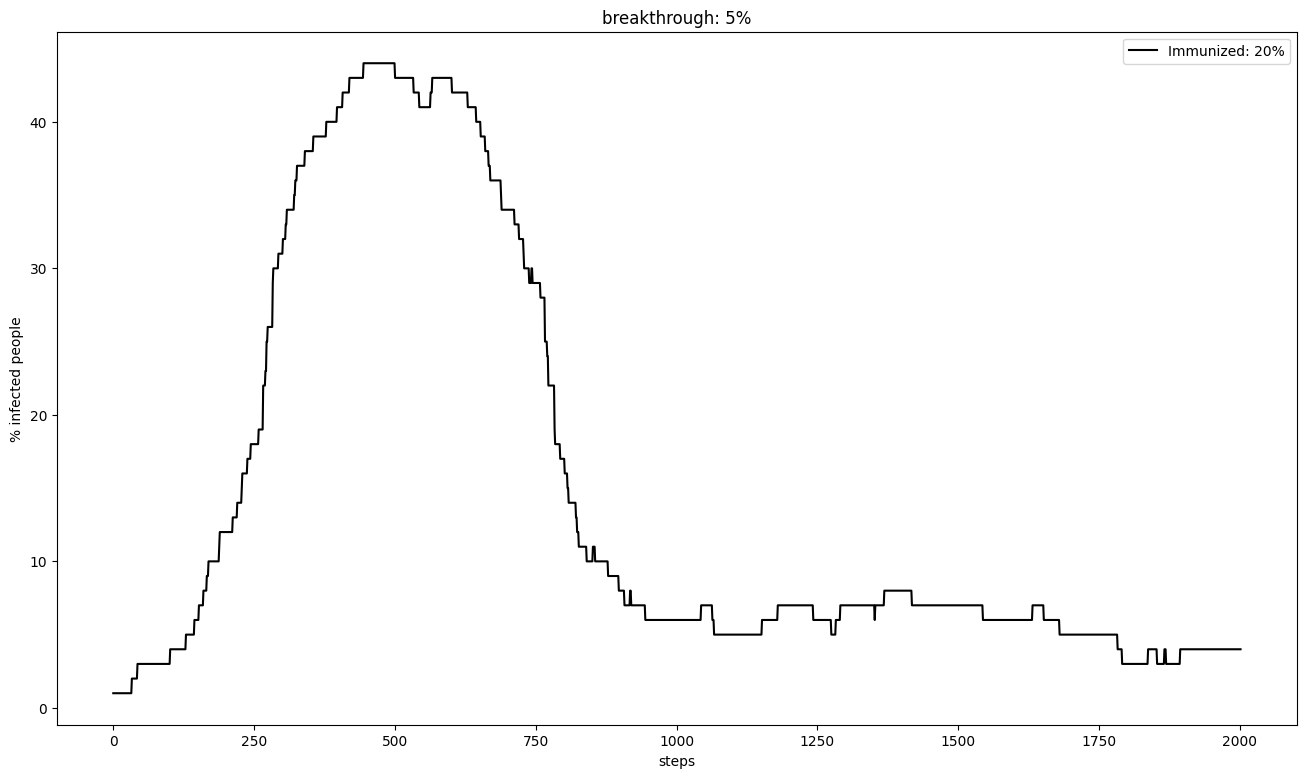

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(0,2001,2001)
label = 'Immunized: 20%'
ax.plot(x, infection_numbers, color='k', label = label)
ax.set_xlabel('steps')
ax.set_ylabel('% infected people')
plt.title('breakthrough: 5%')
plt.legend()
plt.show()

Now run this for different amounts of immunized people and breakthrough probabilities:

In [17]:
breakthrough = np.array([0.01,0.1,0.25,0.5])
n_immunized_people  = np.array([0,0.1,0.25,0.5,0.8])

We let each combination run 20 times to get an average result.

In [18]:
n_iterations = 1
sick_people = np.zeros((n_iterations, breakthrough.size, n_immunized_people.size, 10001))

In [19]:
for k in tqdm(range(n_iterations)):
    box_size = np.array([50,50])
    grid = np.array([10,5])
    n_particles = int(np.prod(grid))
    for i in range(breakthrough.size):
        box = Infection(box_size, n_particles, breakthrough=breakthrough[i], infection_duration=500, boundary=True, rng_seed=420)
        for j in range(n_immunized_people.size):
            box.fill_particles(vel=0.5, mass=0.018, radius=0.5, align='grid',grid=grid)
            box.initialize_infection(n_infected=1, percent_immunized=n_immunized_people[j])
            
            sim = Simulation(box, steps=10000, dt=1)
            sim.run()

            sick_people[k,i,j] = np.sum(np.where(sim.infection_states > 0, 1, 0), axis=0)
    print(f'Run {k} completed.')

100%|██████████| 1/1 [03:39<00:00, 219.39s/it]

Run 0 completed.


In [20]:
# ChatGPT generated these colours
colours = [
    ["#990000", "#009900", "#004C99", "#990099", "#996600"],  # Darkest shades
    ["#E60000", "#00E600", "#0073E6", "#E600E6", "#E69900"],  # Dark shades
    ["#FF1A1A", "#1AFF1A", "#1A8CFF", "#FF1AFF", "#FFB31A"],  # Medium shades
    ["#FF6666", "#66FF66", "#66B3FF", "#FF66FF", "#FFD966"],  # Lightest shades
]




In [21]:
sick_people1 = sick_people/n_particles*100

In [22]:
meaned  = np.mean(sick_people1, axis=0)
stded   = np.std(sick_people1, axis=0)

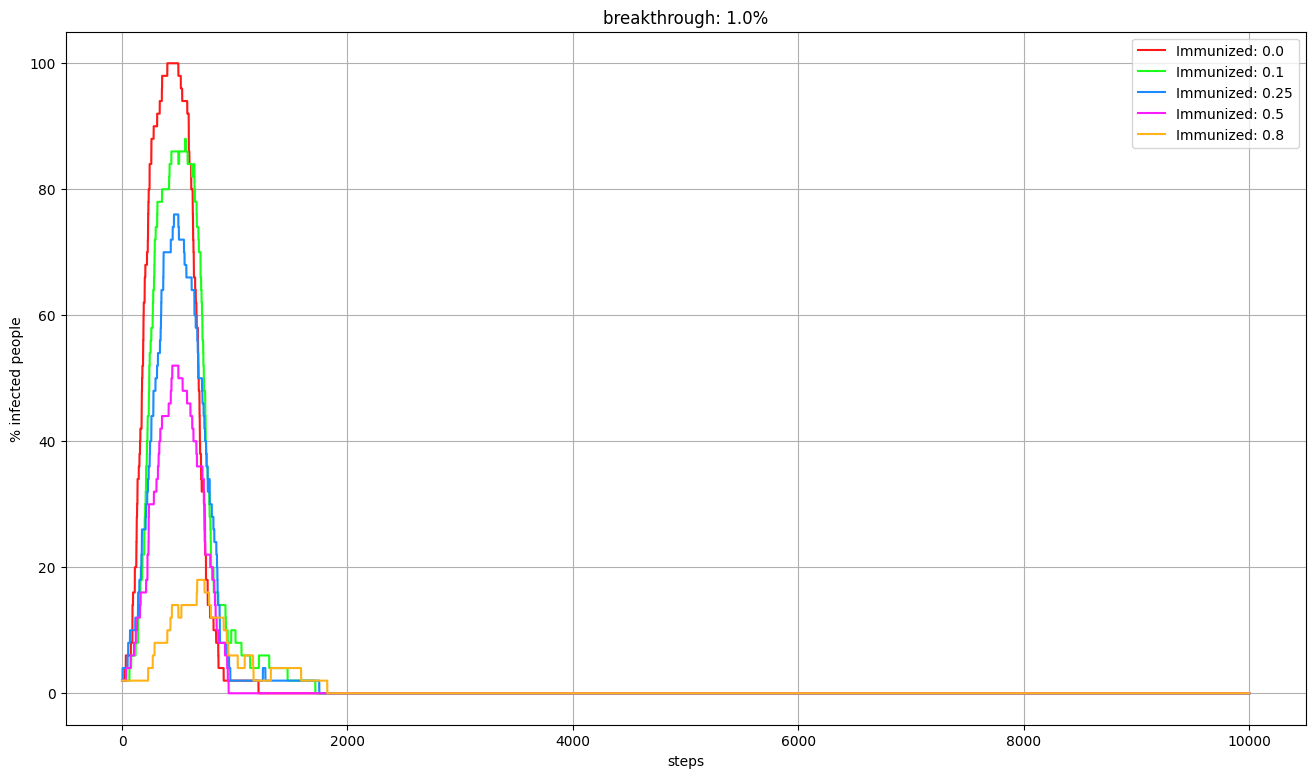

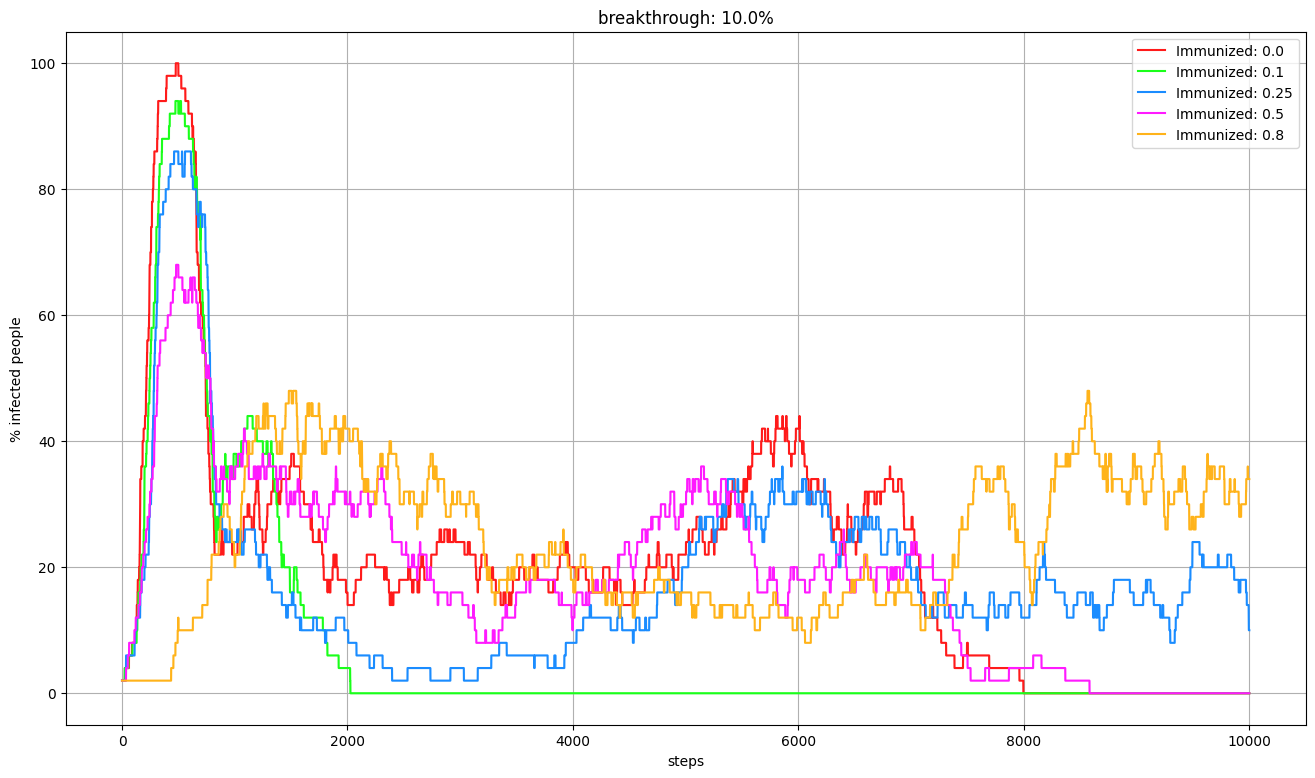

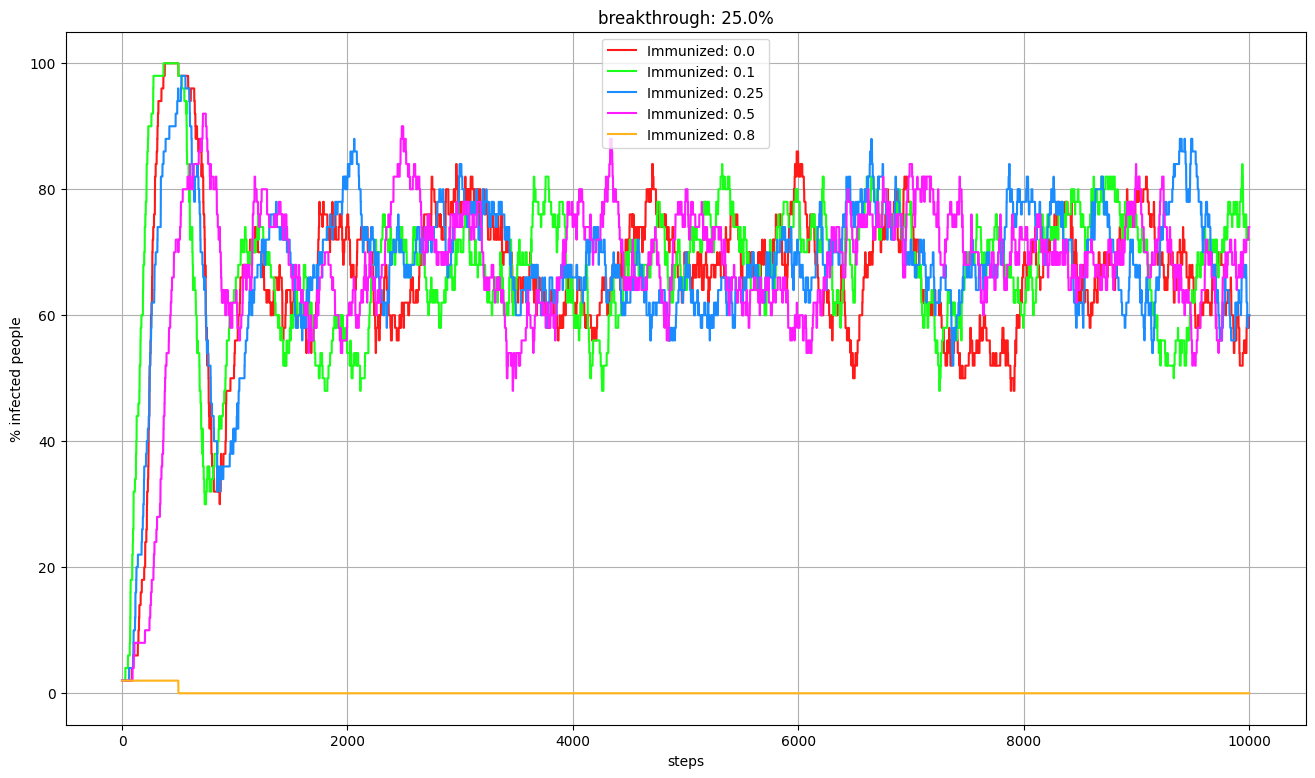

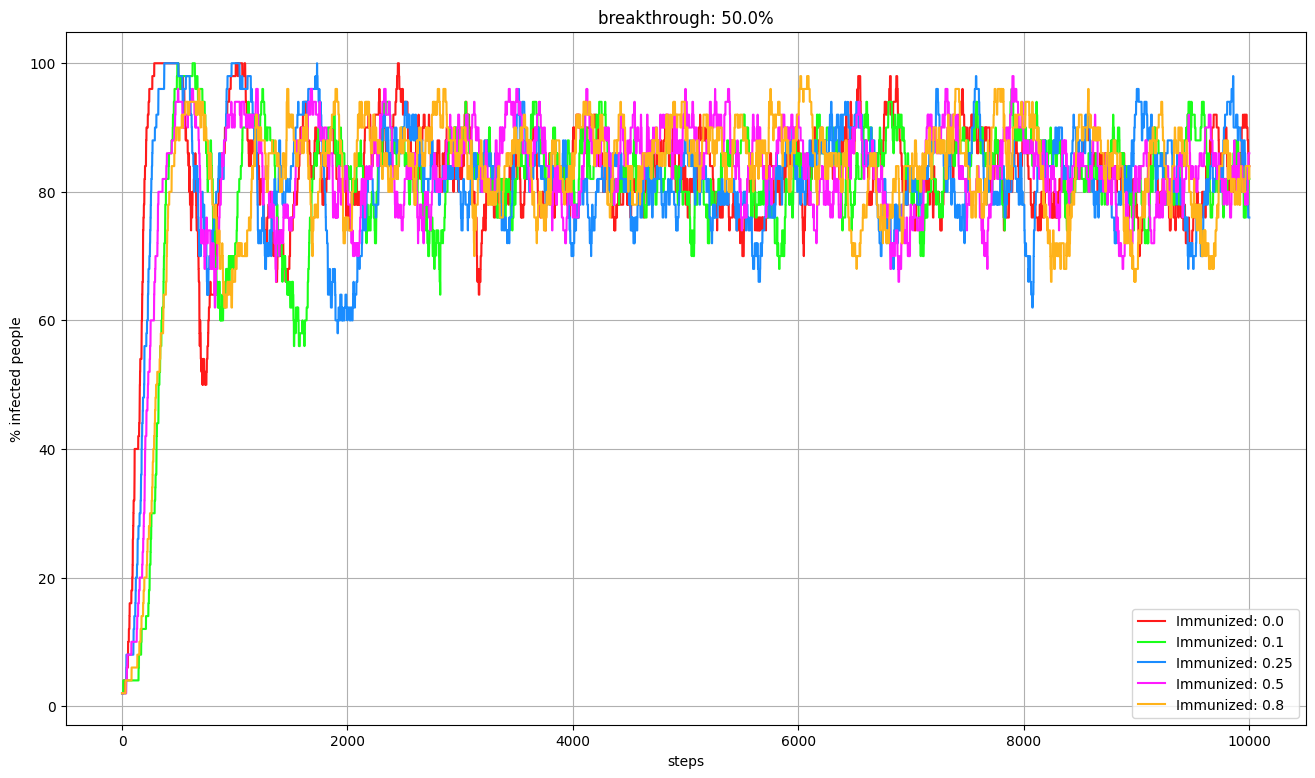

In [23]:
x = np.linspace(0,10001,10001)
for i in range(meaned.shape[0]):
    fig, ax = plt.subplots(figsize=(16, 9))
    for j in range(meaned.shape[1]):
        label = 'Immunized: ' + str(n_immunized_people[j])
        ax.plot(x, meaned[i,j], color=colours[2][j], label = label)
        ax.fill_between(x, meaned[i,j] - stded[i,j], meaned[i,j] + stded[i,j], color=colours[2][j], alpha=0.1)
    ax.set_xlabel('steps')
    ax.set_ylabel('% infected people')
    plt.title('breakthrough: ' + str(breakthrough[i]*100) + '%')
    plt.grid()
    plt.legend()
    plt.show()


In all cases for different breakthrough-percentages we can clearly see a flatter peak for more immunized people which importantly also peaks at a later point in time. 
interestingly for a starting immunization of 0% there often are pronounce peaks at very late stages (see plot 'breakthrough 10%' at step 6000 orplot 'breakthrough 25%' at step 6000-8000).
Currently we have no idea why that is happening or if it is just a statistical anomaly.
For a low breakthrough probability of 1% the desease is erradicated, while for higher values the pandemic turns endemi, fluctuating with around a constant value. 
The initially peridic waves are however oscillating faster for higher breakthrough-prob. 